## Time series 
**adds an explicit order dependence between observations: a time dimension**

**Time dimension is both a constraint and a structure that provides a source of additional information**

**A time series is a sequence of observations taken sequentially in time**

***(ref. Time Series Analysis: Forecasting and Control (Wiley Series in Probability and Statistics))***

**Making predictions about the future is called extrapolation in the classical statistical handling of time series data**
**More modern fields focus on the topic and refer to it as time series forecasting. Forecasting involves taking models fit on historical data and using them to predict future observations**

Descriptive models can borrow for the future (i.e. to smooth or remove noise), they only seek to best describe the data. An important distinction in forecasting is that the future is completely unavailable and must only be estimated from what has already happened.

With timeseries we can work on data description or analysis and or on prediction. 

**In descriptive modeling, or time series analysis, a time series is modeled to determine its components in terms of seasonal patterns, trends, relation to external factors, and the like. In contrast, time series forecasting uses the information in a time series (perhaps with additional information) to forecast future values of that series**

***(ref. Practical Time Series Forecasting with R: A Hands-On Guide [2nd Edition] (Practical Analytics)***

## multi-step time series forecasting: strategies

### seperate models
prediction(t) = model1(obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+1) = model2(obs(t),obs(t-1),obs(t-2),obs(t-3), ..., obs(t-n))


### recursive models 
prediction(t+1) = model(obs(t),obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+2) = model(prediction(t+1),obs(t),obs(t-1), ..., obs(t-n))

### Direct-Recursive Hybrid Strategies
prediction(t+1) = model1(obs(t),obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+2) = model2(prediction(t+1), obs(t), obs(t-1), ..., obs(t-n))

### Multiple output
prediction(t+1), prediction(t+2) = model(obs(t),obs(t-1), obs(t-2), ..., obs(t-n))

## Regression problem

**The forecasting problem is framed as a a regression problem, regression means that the output of model is a continus value. i.e. the goal is to predict the values of each time series in the moment t, by using the values of the previous moment (t-n, t-n+1, t-n+2, ...t-1)**

## univariate

If only one time series is used in the algorithm, it is called univariate forecasting

## multivariate

If multiple time series are used in the algorithm, it's called multivariate forecasting

In [27]:
# univariate data preparation
from numpy import array 
import numpy as np

import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Model packages
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model


In [28]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [29]:
def scale(train, test):
# fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
# transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
# transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [30]:
# inverse scaling for a forecasted value. here the scaler.inverse_transform is used directly
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [31]:
# plot
series = pd.read_csv('Daily_TSNew_i-001683a6-rp-static-server-15197471722.csv',index_col=[0])
series.shape
series.head()

,cpu.percent
time,
2018-11-21 00:00:30,4.1
2018-11-21 00:01:00,4.5
2018-11-21 00:01:30,4.3
2018-11-21 00:02:00,4.4
2018-11-21 00:02:30,4.0


In [32]:
if 'time' in series.columns:
   # Cast the data type    
    series['time'] = series['time'].apply(pd.to_datetime)
    series.set_index('time',inplace=True)
series.head()

,cpu.percent
time,
2018-11-21 00:00:30,4.1
2018-11-21 00:01:00,4.5
2018-11-21 00:01:30,4.3
2018-11-21 00:02:00,4.4
2018-11-21 00:02:30,4.0


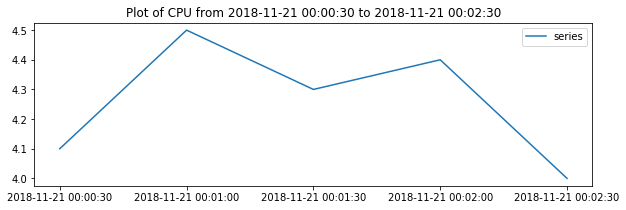

In [33]:
fig = plt.figure(figsize=(10,3))
plt.plot(series[:5], label="series")
plt.title('Plot of CPU from 2018-11-21 00:00:30 to 2018-11-21 00:02:30')
#plt.plot(series.values, label="series")
plt.legend(loc=0)

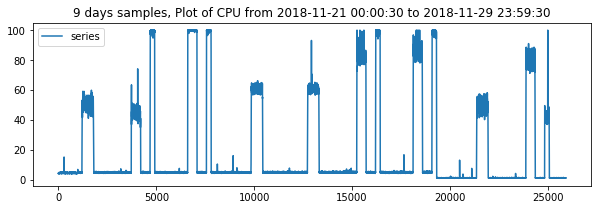

In [34]:
fig = plt.figure(figsize=(10,3))
#plt.plot(series[:100], label="series")
plt.title('9 days samples, Plot of CPU from 2018-11-21 00:00:30 to 2018-11-29 23:59:30')
plt.plot(series.values, label="series")
plt.legend(loc=0)

In [35]:
series = series.values
series.shape

(25911, 1)

In [36]:
from sklearn.preprocessing import MinMaxScaler
# split into train and test sets
train_size = int(len(series) * 0.67)
train, test = series[0:train_size,:], series[train_size:len(series),:]
train.shape, test.shape

((17360, 1), (8551, 1))

In [37]:
# scale data between -1 and 1 
scaler, train_scaled, test_scaled = scale(train, test)
train_scaled, test_scaled
train = train_scaled
test = test_scaled

In [38]:
train

array([[-0.99583767],
       [-0.98751301],
       [-0.99167534],
       ...,
       [-0.98126951],
       [-0.98335068],
       [-0.97710718]])

In [39]:
test

array([[-0.97294485],
       [-0.98335068],
       [-0.97710718],
       ...,
       [-1.0603538 ],
       [-1.05619147],
       [-1.0603538 ]])

In [40]:
# here we construct the supervised-problem table
lag= 3

#create training table for forecasting
trainseriesX, trainseriesy = split_sequence(train, lag)

#create testseriesX and testseriesy
testseriesX, testseriesy = split_sequence(test, lag)

trainseriesX.shape, testseriesX.shape

((17357, 3, 1), (8548, 3, 1))

For a mean squared error regression problem
model.compile(optimizer='rmsprop',
              loss='mse')


In [41]:
# to always shape the data as [samples, timesteps, features]
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1

#seriesX = seriesX.reshape((seriesX.shape[0], seriesX.shape[1], n_features))
trainseriesX = trainseriesX.reshape((trainseriesX.shape[0], trainseriesX.shape[1], n_features))
# scenario1 config

model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(lag, n_features)))
model.add(Dense(1))
sgd = optimizers.SGD()
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
model.summary()
plot_model(model, to_file='usecase2.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [42]:
from keras import optimizers
sgd.get_config()

{'decay': 0.0, 'lr': 0.009999999776482582, 'momentum': 0.0, 'nesterov': False}

In [67]:
from math import sqrt
import math
from sklearn.metrics import mean_squared_error

#demonstrate prediction, the rule is to have the test as testseriesX = testseriesX.reshape(1, n_steps, n_features)
#testseriesX = testseriesX.reshape((testseriesX.shape[0], testseriesX.shape[1], n_features))
#in general the input should be as x_input = x_input.reshape((1, n_steps, n_features))

repeats = 30
error_trainscores = list()

for r in range(repeats):
    # fit model
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='loss', patience=2)
    
    #starting the training on trainseriesX with known trainseriesy
    history = model.fit(trainseriesX, trainseriesy, epochs=100, batch_size=40,callbacks=[early_stopping],verbose=0)
    #history = model.fit(trainseriesX, trainseriesy, epochs=10, verbose=0)
    
    #perform the prediction on the train
    trainPredict = model.predict(trainseriesX, batch_size=40, verbose =0)
    # calculate root mean squared error for train and test 
    trainScore = math.sqrt(mean_squared_error(trainseriesy, trainPredict))
    #report performance for train
    print('%d) Train RMSE: %.3f' % (r+1, trainScore))
    error_trainscores.append(trainScore)

1) Train RMSE: 0.042
2) Train RMSE: 0.041
3) Train RMSE: 0.039
4) Train RMSE: 0.038
5) Train RMSE: 0.037
6) Train RMSE: 0.037
7) Train RMSE: 0.037
8) Train RMSE: 0.036
9) Train RMSE: 0.036
10) Train RMSE: 0.036
11) Train RMSE: 0.036
12) Train RMSE: 0.036
13) Train RMSE: 0.036
14) Train RMSE: 0.036
15) Train RMSE: 0.036
16) Train RMSE: 0.036
17) Train RMSE: 0.036
18) Train RMSE: 0.036
19) Train RMSE: 0.036
20) Train RMSE: 0.036
21) Train RMSE: 0.036
22) Train RMSE: 0.036
23) Train RMSE: 0.036
24) Train RMSE: 0.036
25) Train RMSE: 0.036
26) Train RMSE: 0.036
27) Train RMSE: 0.036
28) Train RMSE: 0.036
29) Train RMSE: 0.036
30) Train RMSE: 0.036


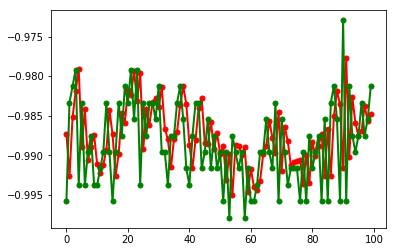

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(trainPredict[100:200], color='red', label='Predictedtrain', marker='o',linewidth=2,markersize=5)
ax.plot(trainseriesy[100:200], color='green', label='trueTrain', marker='o',linewidth=2,markersize=5)


#plt.plot(np.squeeze(cnn_trueValue_net)[:30] , color='red',label='True',marker='o',linewidth=2,markersize=5)


In [75]:
history.params

{'batch_size': 40,
 'do_validation': False,
 'epochs': 100,
 'metrics': ['loss', 'mean_squared_error'],
 'samples': 17357,
 'steps': None,
 'verbose': 0}

In [85]:
testPredict= model.predict(testseriesX, batch_size=40, verbose =0)
# calculate root mean squared error for train and test 
testScore = math.sqrt(mean_squared_error(testseriesy,testPredict))
#report performance for train
print(testScore)

0.04603714302620209


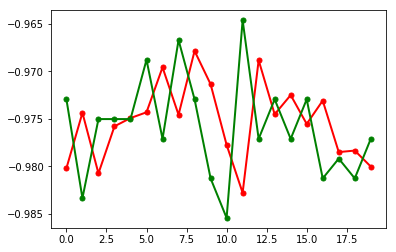

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(testPredict[100:120], color='red', label='Predictedtrain', marker='o',linewidth=2,markersize=5)
ax.plot(testseriesy[100:120], color='green', label='trueTrain', marker='o',linewidth=2,markersize=5)

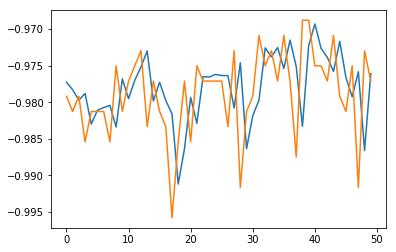

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(testPredict[:50])
ax.plot(testseriesy[:50])

In [96]:
modelmetrics = model.metrics_names
print (modelmetrics)
testeval = model.evaluate(testseriesX, testseriesy, batch_size=40, steps=None)
# this method  Scalar test loss (if the model has no metrics) or list of scalars (if the model computes other metrics).
#the attribute `model.metrics_names` will give you the display labels for the scalar outputs.
traineval= model.evaluate(trainseriesX, trainseriesy, batch_size=40, steps=None)
testeval, traineval, modelmetrics

['loss', 'mean_squared_error']
17357/17357 [==============================] - 0s 14us/step


([0.002119418420808924, 0.002119418420808924],
 [0.001288348170358452, 0.001288348170358452],
 ['loss', 'mean_squared_error'])

## metrics note
Regression is done using different loss functions from classification; 
Mean Squared Error (MSE) is a commonly used loss function for regression.

Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.

The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, 

dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

## LSTM Model Development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

    Samples: These are independent observations from the domain, typically rows of data.
    Time steps: These are separate time steps of a given variable for a given observation.
    Features: These are separate measures observed at the time of observation.
    


In [ ]:
## statistical models are not enough because.


    Focus on complete data: missing or corrupt data is generally unsupported.
    Focus on linear relationships: assuming a linear relationship excludes more complex joint distributions.
    Focus on fixed temporal dependence: the relationship between observations at different times, and in turn the number of lag observations provided as input, must be diagnosed and specified.
    Focus on univariate data: many real-world problems have multiple input variables.
    Focus on one-step forecasts: many real-world problems require forecasts with a long time horizon.
